In [472]:
# for data processing
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas() 
import itertools

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# for nlp
import gensim
from gensim.utils import simple_preprocess
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import nltk
import gensim.corpora as corpora
from gensim.models import CoherenceModel


# download required sources
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-d

True

Only take restaurants into account. We want to find out, what it is what makes restaurants go up or down in rating significantly.

In [2]:
size = 100000
business_chunks = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True,
                    dtype={
                        "business_id": str,
                        "name": str,
                        "address": str,
                        "city": str,
                        "state": str,
                        "postal code": str,
                        "latitude": float,
                        "longitude": float,
                        "stars": float,
                        "review_count": int,
                        "is_open": int
                    }, chunksize=size)

chunk_list = []
for chunk in business_chunks:
    chunk = chunk[chunk['categories'].notnull()]
    
    # only keep restaurants
    chunk = chunk.loc[[('Restaurant' in x) for x in chunk['categories']]]
    
    # only in Vancouver
    chunk = chunk.loc[chunk['city'] == 'Vancouver']
    
    
    # only certain columns
    # chunk = chunk[['business_id', 'name','stars', 'is_open','review_count']]
    
    chunk_list.append(chunk)

restaurants = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)


# EDA on restaurants in Vancouver
A bit of explorative data analysis, to get used to the data and see if our business case is actually valid.

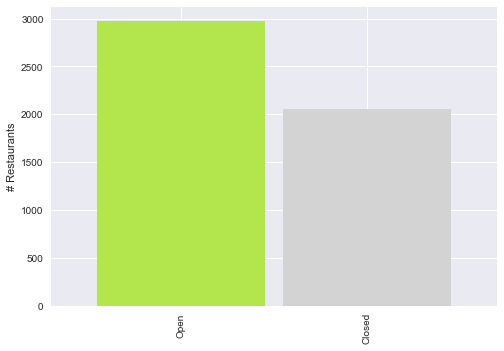

In [212]:
plt.style.use('seaborn')

restaurants['is_open_cat'] = restaurants.is_open.apply(lambda x : 'Open' if x == 1 else 'Closed')

ax = plt.subplot()
restaurants.is_open_cat.value_counts().plot(ax=ax, kind='bar', width=0.9, color=[(0.7,0.9,0.3), 'lightgrey'])
ax.set_ylabel('# Restaurants')
plt.show()

There are a lot of closed restaurants. Let's compare the average star rating.

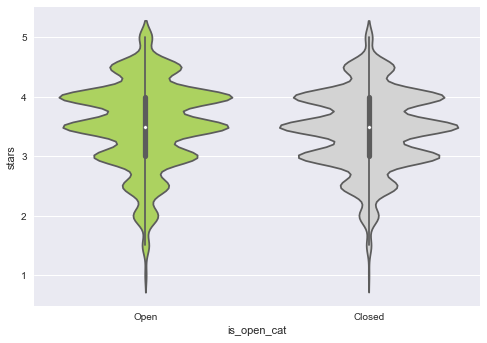

In [64]:
ax = plt.subplot()

my_palette = {"Open": (0.7,0.9,0.3), "Closed": "lightgrey"}

sns.violinplot(x='is_open_cat',y='stars', data=restaurants, ax = ax, palette = my_palette)
plt.show()

The differences between closed and open restaurants is only marginal. I still do expect some differences in the text ratings, though. 

Most users vote around 4 stars. 1 star is extremely seldom (the Canadians are truely polite people 😊). 

Let's now take a look at the restaurants in general. Plot the top 10most occurring categories.

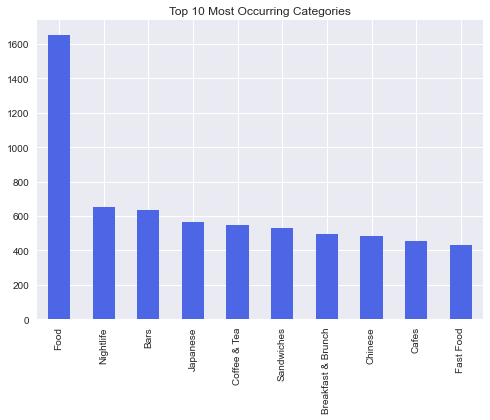

In [114]:
ax = plt.subplot()
categories = restaurants.categories.str.split(', ', expand=True)
categories['business_id'] = restaurants['business_id']
categories.melt('business_id', value_name='category').dropna().sort_values('business_id').query('category != "Restaurants"').category.value_counts()[:10].plot(kind='bar', ax=ax, color=(0.3,0.4,0.9))
ax.set_title('Top 10 Most Occurring Categories')
plt.show()

## Read the reviews
Now read the reviews, to see if they vary over time.

In [88]:
size = 1000000
review_chunks = pd.read_json('../data/yelp_academic_dataset_review.json', lines=True,
                    dtype={
                    "review_id": str,
                    "user_id": str,
                    "business_id": str,
                    "stars": int,
                    "date": str,
                    "text": str,
                    "useful": int,
                    "funny": int,
                    "cool": int,
                }, chunksize=size)

chunk_list = []
for chunk in review_chunks:
    # only keep tips of current or former elite users.
    chunk = chunk[chunk.business_id.isin(restaurants.business_id.unique())]
    chunk_list.append(chunk)

reviews = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

reviews['yearmon'] = reviews['date'].str[0:7]
reviews['year'] = reviews['date'].str[0:4]
reviews['quarter'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d').dt.quarter

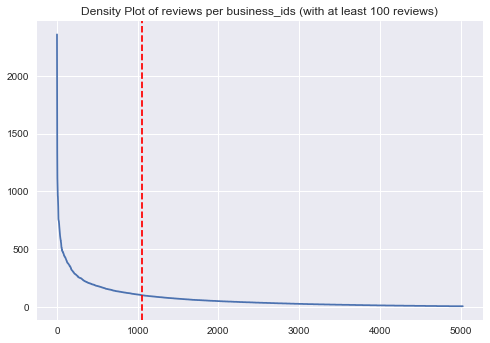

In [155]:
ax = plt.subplot()
line_at = 100

ax.set_title(f'Density Plot of reviews per business_ids (with at least {line_at} reviews)')
business_ids_with_sufficient_reviews = reviews.business_id.value_counts()[reviews.business_id.value_counts() > line_at].index.values
reviews.business_id.value_counts().reset_index()['business_id'].plot(ax=ax)
number_of_businesses_with_sufficient_reviews = sum(reviews.business_id.value_counts() > line_at)
ax.axvline(number_of_businesses_with_sufficient_reviews, linestyle='--', color = 'red')
plt.show()

We have roughly 1000 companies, that have more than 100 reviews. For these, we should be able to get a nice development of star ratings.

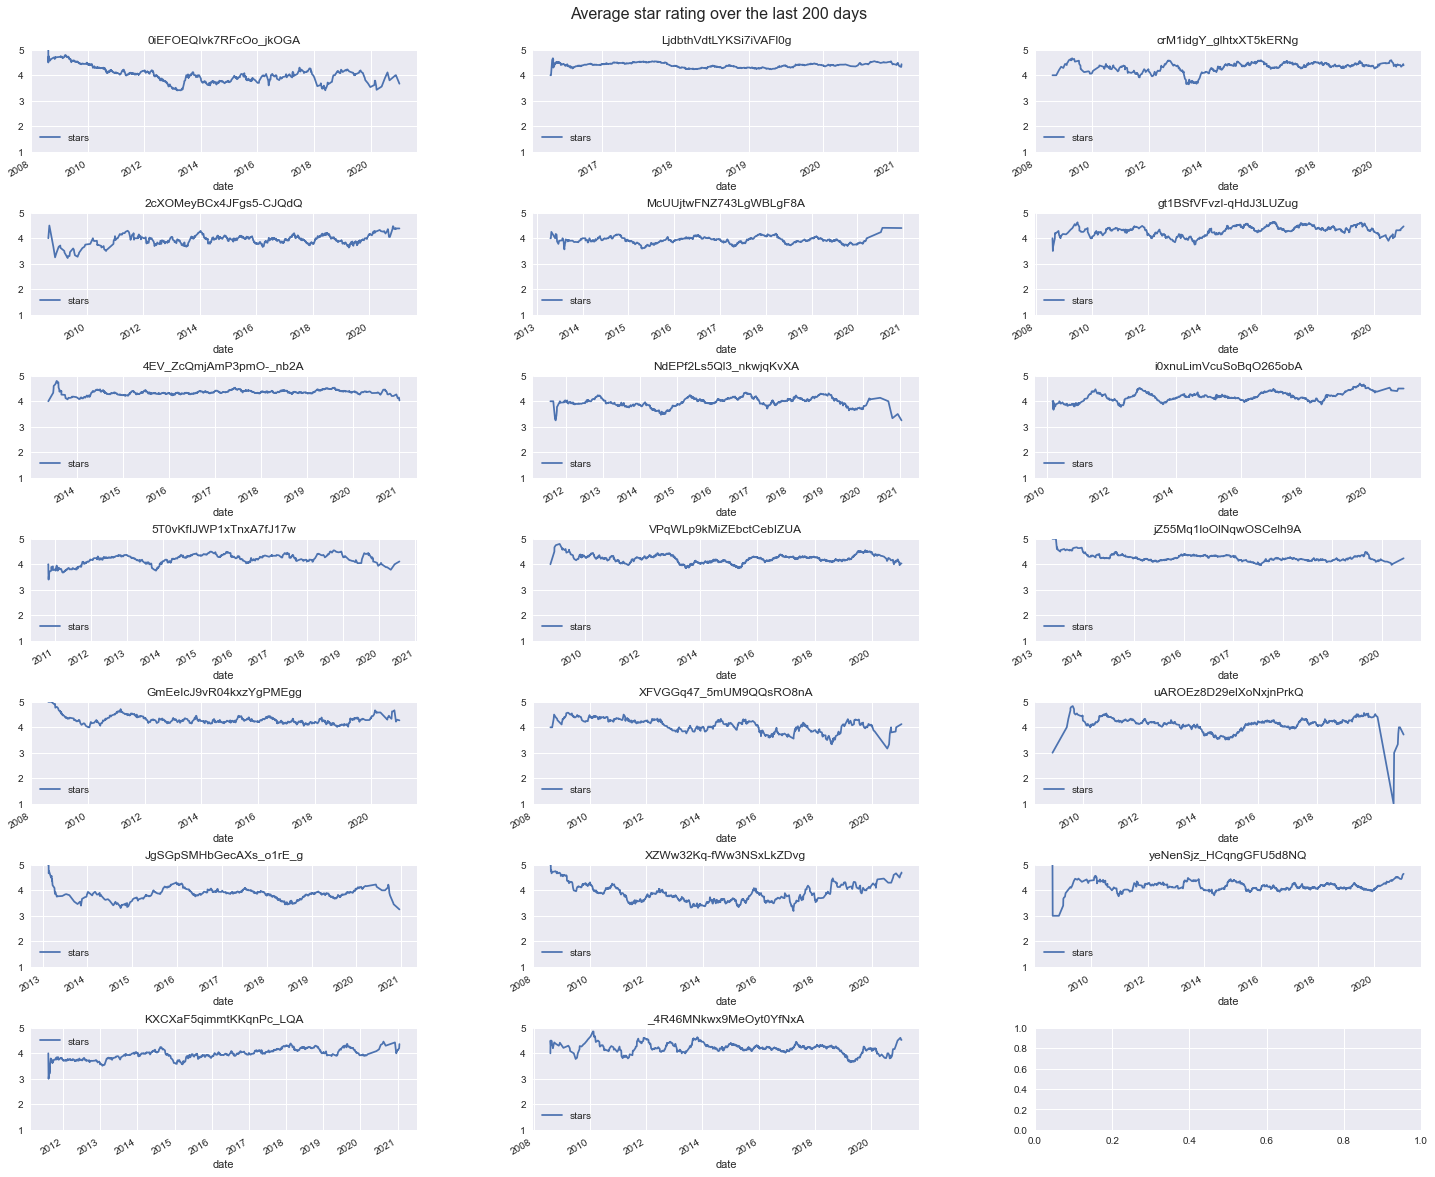

In [214]:
reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')

mean_ratings_top_20 = reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20]), ['business_id', 'stars', 'date']].set_index('date', inplace=False).sort_index().groupby('business_id').rolling(window='200D').agg({'stars': 'mean'})

fig, ax = plt.subplots(7,3, figsize=(20,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.95)
fig.suptitle('Average star rating over the last 200 days', fontsize=16)
y = 0
for i, (name, group) in enumerate(mean_ratings_top_20.groupby('business_id')):
    # calc index
    x = i % 7
    if i != 0 and x == 0:
        y += 1
    
    ax[x,y].set_ylim(1,5)
    group.reset_index().plot(x='date', y='stars', ax=ax[x,y], title=name)
    
    if i ==20:
        break

Some restaurants in this sample vary a bit, but overall they are all pretty much constantly around 4. This might be due to a bias in the users ratings. For example, if a restaurant is well known and has a very good rating, but customers are extremely unhappy, they might resort to rating it 3 stars, whilst at other places they would have rated it 1 star. The _anchor effect_ could be a potential explanation for this behavior.

Additionally, most of the times, users place reviews when they have extreme feelings about the restaurants and will vote accordingly (1 for extremely upset and 5 for extremely happy. Thus, it is unrealistic for businesses to receive constantly ratings close to 5.

However, if we are able to analyze the true sentiment of the users in their textual review, we might be able to ignore the star rating and add a secondary "__sentiment score__". In combination with topic modeling, we could potentially extract topics and assign the sentiment score to the topics. Thus, we would end up with a more granular scoring for e.g. food, service, atmosphere, etc.

With that score, we might be able to give a more realistic view onto things for the businesses, to try and find out what causes a drop in ratings and what they should be working on. We will deliver this as shown above on a rolling window of the last X days. That way, business owners are able to react more quickly to recent changes in their ratings and find out what they need to be working on.

For users, we might be able to add this as additional filters to the search for restaurants. That way users are able to filter the search results with a more realistic search.

# Implementation Plan
<img src='../resources/implementation_plan.jpg' />

1. Sentiment analysis with VADER. VADER was developed to perform well with texts based on social media and therefore is a great choice for the yelp dataset.
2. Topic extraction with LDA. This requires a bit of preprocessing and finetuning. We expect to end up with topics that are relevant to the restaurant business, e.g. food, service, and atmosphere
3. Topic naming with word embeddings. Usually humans have to name the topics found by LDA. However, we want to be totally crazy and use the transitive features of word embeddings and find topic names based on the top X words per topic.
4. Combining the sentiment with the topics to end up with a list of sentiments per topic.

# Choosing a representable subset
If possible, we could take the 20 most reviewed businesses. Let's see if there is anything different about them. If there is, we need to default to a random subsample in order to increase computation times.

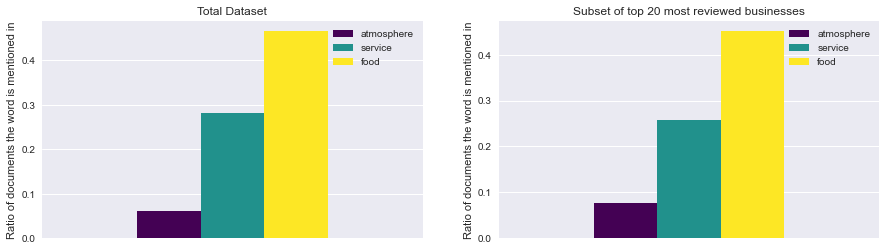

In [263]:
exemplary_occurrences = pd.DataFrame({
    'atmosphere': reviews.text.str.contains('atmosphere').mean(),
    'service': reviews.text.str.contains('service').mean(),
    'food': reviews.text.str.contains('food').mean()
}, index=['Occurences of words'])

exemplary_occurrences_subset = pd.DataFrame({
    'atmosphere': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('atmosphere').mean(),
    'service': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('service').mean(),
    'food': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('food').mean()
}, index=['Occurences of words'])

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].axes.get_xaxis().set_visible(False)
ax[0].set_ylabel('Ratio of documents the word is mentioned in')
ax[0].set_title('Total Dataset')
exemplary_occurrences.plot(kind='bar', ax=ax[0], colormap='viridis')

ax[1].axes.get_xaxis().set_visible(False)
ax[1].set_ylabel('Ratio of documents the word is mentioned in')
ax[1].set_title('Subset of top 20 most reviewed businesses')
exemplary_occurrences_subset.plot(kind='bar', ax=ax[1], colormap='viridis')

plt.show()

The words ratio is about the same for our subset. Let's check, if there are differences in the star ratings.

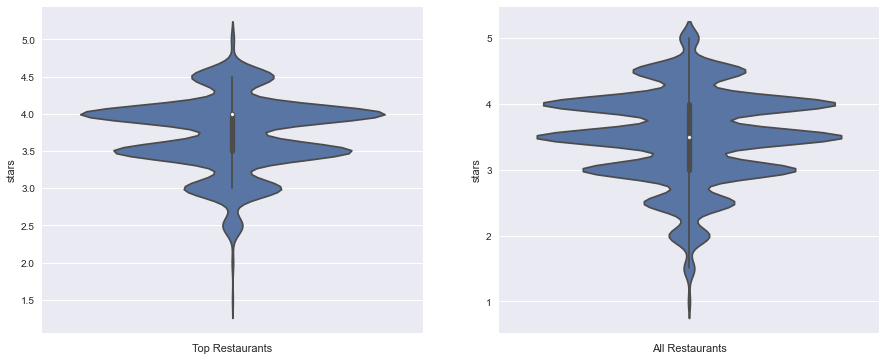

Statistics of top restaurants: µ = 3.72 +- σ 0.49
Statistics of all restaurants: µ = 3.5 +- σ 0.69


In [527]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

plot_data = {'top_restaurants': restaurants.loc[restaurants.business_id.isin(business_ids_with_sufficient_reviews)].stars, 'all_restaurants': restaurants.stars}
# plot_data = [restaurants.loc[restaurants.business_id.isin(business_ids_with_sufficient_reviews)].stars, restaurants.stars]

sns.violinplot(data=plot_data, y = 'top_restaurants', ax = ax[0])
ax[0].set_xlabel('Top Restaurants')
sns.violinplot(data=plot_data, y = 'all_restaurants', ax = ax[1])
ax[1].set_xlabel('All Restaurants')
plt.show()

print(f'Statistics of top restaurants: µ = {round(plot_data["top_restaurants"].mean(),2)} +- σ {round(plot_data["top_restaurants"].std(),2)}')
print(f'Statistics of all restaurants: µ = {round(plot_data["all_restaurants"].mean(),2)} +- σ {round(plot_data["all_restaurants"].std(),2)}')

As this differs a bit too much in my opinion, I will choose a random subsample to bring computation times to a reasonable level for this task. This could easily be changed to include more reviews

In [533]:
sampled_restaurants = restaurants.business_id.sample(100, random_state=42)
subsample = reviews[reviews.business_id.isin(sampled_restaurants)]
subsample.shape

(7093, 12)

# Sentiment analysis with VADER

In [534]:
top20_reviews = subsample # im too lazy to change the code now.

In [535]:
# top20_reviews = reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])]

words = set(nltk.corpus.words.words())
def remove_non_english(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or w.isdigit())

print(top20_reviews.shape)
top20_reviews = top20_reviews.assign(english=top20_reviews.text.map(remove_non_english))
top20_reviews = top20_reviews[top20_reviews.english != '']
print(top20_reviews.shape)

def tokenize_and_score(row):
    tokenized_sentences = tokenize.sent_tokenize(row)
    
    scores = list(map(lambda x : sid.polarity_scores(x)['compound'], tokenized_sentences))
    
    return tokenized_sentences, scores

top20_reviews['tokenized'], top20_reviews['scores'] = zip(*(top20_reviews.text.progress_map(tokenize_and_score)))

# # TODO: should be done in one map with the scoring.
# top20_reviews = top20_reviews.assign(tokenized=top20_reviews.text.map(lambda x: tokenize.sent_tokenize(x)))

# # vader score
# top20_reviews = top20_reviews.assign(score=top20_reviews.text.map(lambda x : sid.polarity_scores(x)['compound']))

top20_reviews[['text', 'tokenized', 'scores']].head(10)

(7093, 12)
(7089, 13)


100%|█████████████████████████████████████████████████████████████████████████████| 7089/7089 [00:39<00:00, 177.71it/s]


,text,tokenized,scores
73,We came in on a Friday in the early afternoon....,[We came in on a Friday in the early afternoon...,"[0.0, 0.3291, 0.3703, -0.501, 0.4939, 0.4019, ..."
143,One of several Korean places in this part of t...,[One of several Korean places in this part of ...,"[0.0, 0.0, 0.7269, 0.7579, 0.6249, 0.5413, 0.0..."
159,Pretty good breakfast. I came back for the egg...,"[Pretty good breakfast., I came back for the e...","[0.7269, 0.0, 0.7351, 0.6369, 0.0, -0.34, 0.0,..."
179,Went here with my friend last week for Naengmy...,[Went here with my friend last week for Naengm...,"[0.4939, 0.0, 0.0, 0.25, 0.4588, -0.3412, -0.1..."
225,Came here around 1:30 on a Sunday with my wife...,[Came here around 1:30 on a Sunday with my wif...,"[0.0, 0.3506, 0.0, 0.0, -0.0444, 0.128, 0.0, -..."
251,Nothing too special about this place. Not tren...,"[Nothing too special about this place., Not tr...","[-0.3089, 0.2755, 0.0, -0.2351, 0.0, -0.6115, ..."
273,My wife and I loved the food here. I had the ...,"[My wife and I loved the food here., I had the...","[0.5994, 0.0, 0.5719, 0.0]"
548,"Thankfully, our co-diners speak Cantonese, so ...","[Thankfully, our co-diners speak Cantonese, so...","[-0.3321, 0.0, 0.5983, 0.7227, 0.6124, 0.8173,..."
577,This buffet is probably the worse buffet I hav...,[This buffet is probably the worse buffet I ha...,"[-0.4767, -0.3356, 0.5994, 0.0, 0.0]"
599,"Everything is so good! Place, food and service...","[Everything is so good!, Place, food and servi...","[0.6166, 0.6476, 0.3367]"


__Caveat:__ We should probably do it per sentence, as some sentences have separat topics. E.g. "Baristas are great. All other staff is soooo lost and vacant."

Solved

# LDA Topic Modelling
Game Plan for this step:
1. Basic preprocessing (lower case)
2. POS Tagging and filter to only nouns (relevant to topics)
3. Removal of stop words // there should not be any at this point anymore, but just to make sure
4. Stem words
5. Run LDA on the preprocessed text as a whole document.

__Caveat:__ We should do this per sentence to get a more fine-grain result. For now, we will stick with this solution, however.

Solved

For reference of the available POS tags in nltk refer to `nltk.help.upenn_tagset()`

In [536]:
#POS tagging first to utilize sentences
stemmer = SnowballStemmer('english')

def pos_tagging(row):
    return list(filter(lambda x: x != [], [keep_nouns(sentence) for sentence in row]))

def preprocess(sentence):
    '''
    0. Convert to lower case
    1. Only allow nouns. 
    2. Remove stopwords
    3. Remove frequent words with TF-IDF?
    4. Stem words
    '''
    pos_tag_tuples = nltk.pos_tag(nltk.word_tokenize(sentence.lower())) # lower case to avoid weird nouns
    
    nouns = []
    for pos_tag_tuple in pos_tag_tuples:
        if pos_tag_tuple[1] in [
            'NN', 'NNS', 'NNP', 'NNPS' # nouns
            'JJ', 'JJR', 'JJS' # adjectives
        ]:
            # keep the word
            # but only if it is not a stop word
            if pos_tag_tuple[0] not in stopwords.words('english'):
                nouns.append(stemmer.stem(pos_tag_tuple[0]))
    
    return nouns


top20_reviews = top20_reviews.assign(noun_sentences = top20_reviews.tokenized.progress_map(pos_tagging))
# tmp = top20_reviews.head(10).tokenized.progress_map(pos_tagging)

100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [06:26<00:00, 18.33it/s]


In [537]:
list_of_sentences = list(itertools.chain.from_iterable(top20_reviews['noun_sentences'].values))

In [ ]:
coherences = []
best_model = None

In [566]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=10000,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence(), lda_model


ks = range(111,132,10)
for k in ks:
    print(f'Computing {k}')
    c, m = compute_coherence_values(corpus, id2word, k, 0.1, 0.3)
    if best_model is None or c > max(coherences):
        best_model = m
    coherences.append(c)

Computing 111
Computing 121
Computing 131


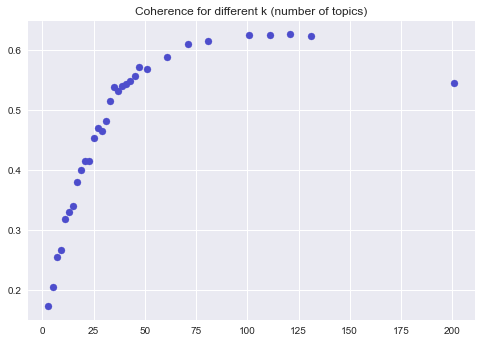

In [571]:
ks = list(range(3,48,2)) +[101,201, 51,61,71,81, 111, 121, 131] # [3,5,7,9,11,13,15,17,19,21,23,25]
ax = plt.subplot()
ax.scatter(ks, coherences, color = (0.3,0.3,0.8))
ax.set_title('Coherence for different k (number of topics)')
plt.show()

In [577]:
lda_model = best_model

The best model contains 121 topics. This will be a pain to cluster manually. Can word embeddings help?

In [538]:
# Create Dictionary
id2word = corpora.Dictionary(list_of_sentences)

# Create Corpus
texts = list_of_sentences

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [578]:
import pyLDAvis.gensim_models
import pickle 
import os
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('../results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, '../results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\ProgramData\Anaconda3\envs\yelp\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22    -0.310347  0.014785       1        1  1.586925
79    -0.011386 -0.093982       2        1  1.583842
47    -0.261609  0.045554       3        1  1.435842
36    -0.041381 -0.285364       4        1  1.332610
39    -0.009596 -0.033690       5        1  1.326426
...         ...       ...     ...      ...       ...
76     0.000261 -0.001546     117        1  0.650021
21     0.000168 -0.001322     118        1  0.649826
69     0.000303 -0.002008     119        1  0.646657
112   -0.000229 -0.002162     120        1  0.645918
94    -0.000401 -0.002744     121        1  0.645797

[121 rows x 5 columns], topic_info=         Term         Freq        Total  Category  logprob  loglift
57       food  1488.000000  1488.000000   Default  30.0000  30.0000
41      place  1267.000000  1267.000000   Default  29.0000  29.0000
151      time   849.000000   849.000000   Default  28.0000  28.0000
4      servic   761.000000   761.000000   Default  27.0000  27.0000
33    restaur   658.000000   658.000000   Default  26.0000  26.0000
...       ...          ...          ...       ...      ...      ...
9778    fogey     0.585879    12.672968  Topic121  -7.5758   1.9683
9411  bacardi     0.585505    12.674123  Topic121  -7.5765   1.9676
9012     ~me~     0.572171    12.672838  Topic121  -7.5995   1.9447
3900    drunk     0.630816    18.707769  Topic121  -7.5019   1.6528
3497      rum     0.585508    16.340842  Topic121  -7.5765   1.7135

[3914 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
996      59  0.796812           %
4113     59  0.064687          'n
4113     73  0.129373          'n
665     102  0.855332           *
997      97  0.585249           +
...     ...       ...         ...
9012    121  0.078909        ~me~
9573     99  0.079006       étoil
3235     72  0.074835           ‍
9362    117  0.078950        我家牛排
8377    116  0.078919  ，而verde是綠色

[5141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 80, 48, 37, 40, 112, 56, 27, 78, 76, 30, 58, 97, 19, 118, 1, 98, 10, 74, 75, 35, 71, 26, 62, 107, 105, 3, 45, 7, 90, 6, 114, 49, 65, 57, 117, 60, 47, 109, 17, 28, 94, 106, 33, 54, 88, 44, 84, 111, 121, 50, 87, 104, 72, 2, 63, 12, 69, 67, 25, 4, 89, 102, 43, 96, 66, 36, 24, 34, 81, 55, 8, 5, 83, 115, 64, 79, 59, 85, 108, 39, 32, 14, 110, 100, 51, 46, 119, 120, 11, 82, 18, 73, 93, 9, 53, 41, 99, 103, 20, 16, 61, 15, 52, 68, 92, 21, 29, 31, 38, 101, 91, 42, 116, 86, 13, 77, 22, 70, 113, 95])

Possibly replace LDA with https://github.com/adjidieng/ETM in the future. Seems promising

In [365]:
# human assigns titles to topics
food = [1, 4, 6, 11, 12]
service = [5, 7, 8, 9] # 9 could be separated as time
atmosphere = [2,3]
price = [10]

use categories to assign sentiment of vader to text

In [405]:
def get_topic_scores(row):
    if row.noun_sentences == []:
        # return same score for each category
        return np.sum(row.scores), np.sum(row.scores), np.sum(row.scores), np.sum(row.scores)
    sentences_bow = [id2word.doc2bow(text) for text in row.noun_sentences]
    sentence_scores = list(lda_model.get_document_topics(sentences_bow))
    score_food = 0
    score_service = 0
    score_price = 0
    score_atmosphere = 0
    for topic_scores, vader_score in zip(sentence_scores, row.scores):
        topics, scores = zip(*topic_scores)
        topic = topics[np.argmax(scores)]
        if topic in food:
            score_food += vader_score
        if topic in atmosphere:
            score_atmosphere += vader_score
        if topic in service:
            score_service += vader_score
        if topic in price:
            score_price += vader_score
    return score_food, score_service, score_price, score_atmosphere
    

top20_reviews['score_food'], top20_reviews['score_service'], top20_reviews['score_price'], top20_reviews['score_atmosphere'] = \
    zip(*top20_reviews.progress_apply(get_topic_scores, axis=1))

100%|███████████████████████████████████████████████████████████████████████████| 21897/21897 [01:57<00:00, 186.86it/s]


add scores together and scale from 1 - 5 for each restaurant

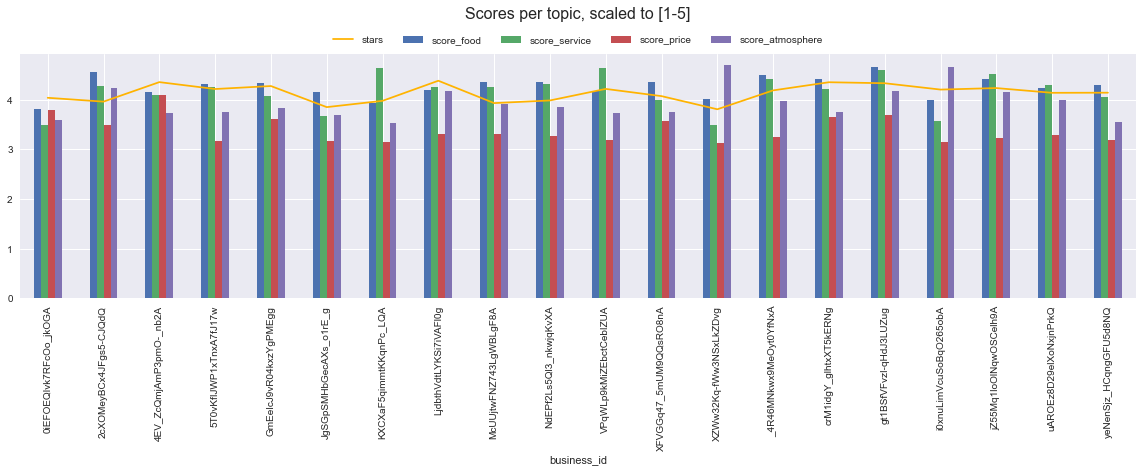

In [468]:
def normalize(x):
    #        (b-a)(x - min)
    # f(x) = --------------  + a
    #          max - min
    
    return (((5.0-1.0)*(np.mean(x)+1)) / (1.0 + 1.0)) + 1

businesses_with_ratings = top20_reviews.groupby('business_id').agg({'score_food': normalize, 'score_service': normalize, 'score_price': normalize, 'score_atmosphere': normalize, 'stars': 'mean'})

fig, ax = plt.subplots(1,1,figsize=(20,5))
businesses_with_ratings.plot(y=['score_food', 'score_service', 'score_price', 'score_atmosphere'], kind='bar', ax=ax)
businesses_with_ratings.plot(y=['stars'], kind='line', ax=ax, color=(1,0.7,0))

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1),
          fancybox=True, shadow=True, ncol=5)
ax.set_title('Scores per topic, scaled to [1-5]', y=1.2, pad=-14, fontsize=16)

plt.xticks(rotation=90)
plt.show()

# Hyperparameter Tuning

First, choose # topics according to highest coherence score for LDA model.

This is done by retraining the model with different topic numbers and seeing how the coherence develops.

> Coherence measures the relative distance between words within a topic. C_V is typically 0 < x < 1

After having chosen a good amount of topics, we can then tune the hyperparameters alpha and beta to return good-looking topics. As we train on single sentences, it is very likely that we have only one single topic per sentence. Thus, our alpha should be rather low. Additionally, we can think about making it asymmetric, to fit the distribution we have shown regarding food, service and atmosphere in a better fashion.

In [481]:
c, m = compute_coherence_values(corpus, id2word, 8, 0.1, 0.3)
c

KeyboardInterrupt: 

In [476]:
len([c for c in corpus if c != []])

168675

In [477]:
len(corpus)

168675

Two things I realize.

1. My dataset is too biased on restaurants with good ratings (we have only the top restaurants, and they usually have high ratings, if they have so many, it means many ppl go there and therefore it must not be shabby)
2. LDA could possibly perform better, if I only train it on nouns and use VADER for sentiment regarding those nouns. Maybe then I am able to split 

In [222]:
#importing wordtovec embeddings 
from gensim.models import KeyedVectors
pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

KeyboardInterrupt: 